### Libraries and Settings

In [116]:
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import seaborn as sns

%matplotlib inline

In [71]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

### Import Data

In [72]:
def create_dataframe(links_dict):
    """
    This function reads in each url passed to it and concatenates them into a pandas dataframe.
    ---
    IN: links_dict (dict) where the keys are user-defined and the values are urls to csv files.
    OUT: Pandas DataFrame
    """
    frames = []
    for week, link in links_dict.items():
        frames.append(pd.read_csv(link))
    return pd.concat(frames)

In [85]:
links_dict = {'05-06-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170506.txt',
              '05-13-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt',
              '05-20-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170520.txt',
              '05-27-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170527.txt',
              '06-03-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt',
              '06-10-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170610.txt',
              '06-17-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170617.txt',
              '06-24-2017': 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt'}

In [74]:
df = create_dataframe(links_dict)

### Clean Data

In [75]:
def clean_column_names(df):
    """
    This function removes whitespace from column names and converts each name to lowercase.
    It also changes some column names to preferred values.
    ---
    IN: Pandas DataFrame
    OUT: No output. Modifies dataframe in place.
    """
    
    for col in df.columns:
        df.rename(columns = {col: col.strip().lower()}, inplace = True)
        
    df.rename(columns = {'entries': 'cumm. entries', 'exits': 'cumm. exits'}, inplace = True)    

In [76]:
def convert_to_datetime(df):
    """
    Converts the dates and timestamps provided in the MTA data into datatimes.
    ---
    IN: Pandas DataFrame
    OUT: No output. Modifies dataframe in place.
    """
    # Combine date and time
    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%m/%d/%Y %H:%M:%S')
    df['day'] = df['datetime'].dt.dayofweek
    
    # Convert time from string to datetime time (This produces a warning that we ignore)
    df['time'] = pd.to_datetime(df['time'], format = '%H:%M:%S').dt.time

In [77]:
clean_column_names(df)
convert_to_datetime(df)

### Calculate Marginal Entries and Exits

In [78]:
def calculate_entries_and_exits(df, groupby_columns):
    """
    Groups the specified DataFrame (df) by the list of columns names provided (groupby_columns).
    Then calculates entry and exit values from 
    ---
    IN: Pandas DataFrame, list of column names to groupby
    OUT: No output. Modifies dataframe in place.
    """
    
    # Calculate marginal entries and exits using abs() because some turnstiles count backwards
    df['entries'] = df.groupby(groupby_columns)['cumm. entries'].transform(lambda x: abs(x - x.shift(1)))
    df['exits']   = df.groupby(groupby_columns)['cumm. exits'].transform(lambda x: abs(x - x.shift(1)))
    df['people'] = df['entries'] + df['exits']

In [79]:
def format_times(df, groupby_columns):
    """
    Changes time values from strings to datetimes. Calculates entries and exits per hour.
    ---
    IN: Pandas DataFrame, list of column names to groupby
    OUT: No output. Modifies dataframe in place.
    """
    # Calculate entries and exits per hour
    df['timedelta'] = df.groupby(groupby_columns)['datetime'].transform(lambda x: x - x.shift(1))    
    df['timedelta'] = df['timedelta'].transform(lambda x: x.seconds//3600)
    
    df['entries per hour'] = df['entries']/df['timedelta']
    df['exits per hour'] = df['exits']/df['timedelta']
    df['people per hour'] = df['entries per hour'] + df['exits per hour']

In [80]:
groupby_columns = ['station', 'linename', 'unit', 'c/a', 'scp']
calculate_entries_and_exits(df, groupby_columns)
format_times(df, groupby_columns)

### Save and Load pickled data

In [81]:
filepath = '/Users/Joe/Documents/Metis/Projects/metis-one-Benson/pickled-dataframes/'
filename = 'cleaned_df.pkl'
filename_may = 'first_week_of_may_df.pkl'

Save

In [82]:
with open(filepath + filename, 'wb') as picklefile:
    pickle.dump(df, picklefile)

Open

In [5]:
with open(filepath + filename, 'rb') as picklefile: 
    df = pickle.load(picklefile)

### Station Names
Cleaning Station names to match zip code data

In [6]:
df['station'] = df['station'].str.replace('/', '-')
df['station'] = df['station'].str.replace('TH', '')
df['station'] = df['station'].str.replace('STREET', 'ST');
#df['station'] = df['station'].str.replace('EAST', 'E')
#df['station'] = df['station'].str.replace('WEST', 'W');

In [7]:
df['station linename'] = df['station'] + ' ' + df['linename']

In [8]:
station_rename = {'Wrong': 'Right',
                  '14 ST FLM123': '14 ST 123FLM',
                  '14 ST-UNION SQ 456LNQRW': '14 ST-UNION SQ LNQR456W',
                  '168 ST AC1': '168 ST 1AC',
                  '42 ST-PORT AU ACENGRS1237W': '42 ST-PORT AU ACE',
                  '42 ST-PORT AU ACENQRS1237W': '42 ST-PORT AU ACE',
                  '4AV-9 ST DFGMNR': '4 AV-9 ST DFGMNR',
                  '59 ST COLUMBUS ABCD1': '59 ST COLUMBUS 1ABCD',
                  '59 ST NQR456W': '59 ST 456NQRW',
                  '59 ST NRW': '59 ST 456NQRW',
                  'ATL AV-BARCLAY BDNQR2345': 'ATL AV-BARCLAY 2345BDNQR',
                  'BOROUGH HALL R2345': 'BOROUGH HALL 2345R',
                  'COURT SQ EMG': 'COURT SQ-23 ST EMG',
                  'FULTON ST ACJZ2345': 'FULTON ST 2345ACJZ',
                  'TIMES SQ-42 ST 1237ACENQRSW': 'TIMES SQ-42 ST 1237ACENQRS',
                  'TIMES SQ-42 ST ACENQRS1237W': 'TIMES SQ-42 ST 1237ACENQRS'}

In [9]:
#for station in sorted(df['station linename'].unique()):
    #print(station)

In [10]:
for wrong, right in station_rename.items():
    df.replace(wrong, right, inplace=True)

### Finding Errors in the data
Rows with large timedeltsas could be a potentials source of error. Fortunately, they are fringe.

In [11]:
df['timedelta'].value_counts()

4.0     1549140
0.0        7063
3.0        3798
1.0        3135
2.0        3100
8.0        1931
12.0        149
16.0         73
20.0         44
5.0          26
19.0         12
6.0          12
10.0         11
21.0         11
17.0         10
22.0         10
18.0          8
7.0           8
15.0          6
14.0          6
13.0          6
11.0          6
9.0           5
23.0          2
Name: timedelta, dtype: int64

In [12]:
# When the timedelta is near zero, calculating people per hour yields infinity.
df = df.loc[(df['timedelta'] > 0) & (df['timedelta'] <= 4)]

Rollover points create artificially high values. Singe entry or exit values above 3000 imply a rollover.

In [13]:
upper_limit = 3000
df = df[(df['entries'] <= upper_limit) & (df['exits'] <= upper_limit)]

### Busiest Stations

Stations with the most total traffic. These match well enough to the [busiest stations](http://web.mta.info/nyct/facts/ffsubway.htm) listed by the MTA.

In [14]:
df.groupby(['station linename']).sum().sort_values('entries', ascending = False).head(10)

,cumm. entries,cumm. exits,day,entries,exits,people,timedelta,entries per hour,exits per hour,people per hour
station linename,,,,,,,,,,
GRD CNTRL-42 ST 4567S,1040462010014,701465465854,61301,6.601e+06,5.913e+06,1.251e+07,81080.0,1.689e+06,1.539e+06,3.228e+06
34 ST-HERALD SQ BDFMNQRW,1583255722669,1888711353155,54028,6.246e+06,5.440e+06,1.169e+07,71957.0,1.570e+06,1.375e+06,2.945e+06
14 ST-UNION SQ LNQR456W,366566762741,103237216592,37918,5.332e+06,4.543e+06,9.875e+06,50618.0,1.334e+06,1.137e+06,2.471e+06
TIMES SQ-42 ST 1237ACENQRS,1951053403581,1514336326147,50146,5.119e+06,4.636e+06,9.755e+06,66756.0,1.289e+06,1.172e+06,2.461e+06
42 ST-PORT AU ACE,2510134698932,2092403685843,50790,5.105e+06,3.571e+06,8.676e+06,67449.0,1.306e+06,9.039e+05,2.210e+06
34 ST-PENN STA 123,786688416831,455312805428,42035,4.210e+06,3.419e+06,7.629e+06,55924.0,1.079e+06,8.643e+05,1.943e+06
FULTON ST 2345ACJZ,1376155564132,1418435174044,89187,4.159e+06,3.376e+06,7.535e+06,118909.0,1.045e+06,8.516e+05,1.897e+06
34 ST-PENN STA ACE,159127300962,81778671372,55880,3.867e+06,3.379e+06,7.246e+06,74405.0,9.705e+05,8.472e+05,1.818e+06
59 ST 456NQRW,1378735573732,807855135819,53213,3.856e+06,2.895e+06,6.751e+06,70670.0,9.827e+05,7.329e+05,1.716e+06


#### Busiest Morning and Evening Rushhour  
First, filter by day.

In [15]:
weekday = df[df['day'] < 5]
weekend = df[df['day'] >= 5]

Then, filter by time of day

In [16]:
morning_rush = weekday.loc[(weekday['time'] > datetime.time(6,0)) & (weekday['time'] <= datetime.time(12,0))]
evening_rush = weekday.loc[(weekday['time'] > datetime.time(16,0)) & (weekday['time'] <= datetime.time(20,0))]
midday = weekday.loc[(weekday['time'] > datetime.time(12,0)) & (weekday['time'] <= datetime.time(16,0))]

Stations with fewer turnstiles will have higher average entries and exits in this dataset. For example, York St. is a low traffic station and may only have a couple of turnstiles. Grand Central is super busy, so the MTA installs many turnstiles. Each turnstile at Grand Central may see on average less people even while all the turnstiles as Grand Central see more total people.

In [17]:
df.groupby(['station linename']).mean().sort_values('entries', ascending=False).head(5)

,cumm. entries,cumm. exits,day,entries,exits,people,timedelta,entries per hour,exits per hour,people per hour
station linename,,,,,,,,,,
YORK ST F,1.193e+07,1.047e+07,3.002,532.845,255.333,788.178,3.994,133.417,63.987,197.403
MYRTLE AV JMZ,8.536e+06,7.414e+06,2.976,478.339,290.092,768.431,3.964,122.069,73.251,195.319
GRAND ST BD,3.759e+07,1.832e+08,2.969,462.137,346.660,808.796,3.985,116.203,87.574,203.777
96 ST 6,1.432e+07,5.002e+06,2.985,433.603,124.921,558.524,3.964,110.139,31.867,142.006
14 ST-UNION SQ LNQR456W,2.895e+07,8.153e+06,2.994,421.107,358.734,779.841,3.997,105.359,89.815,195.174


In [18]:
df.groupby(['station linename']).sum().sort_values('entries', ascending=False).head(5)

,cumm. entries,cumm. exits,day,entries,exits,people,timedelta,entries per hour,exits per hour,people per hour
station linename,,,,,,,,,,
GRD CNTRL-42 ST 4567S,1040462010014,701465465854,61301,6.601e+06,5.913e+06,1.251e+07,81080.0,1.689e+06,1.539e+06,3.228e+06
34 ST-HERALD SQ BDFMNQRW,1583255722669,1888711353155,54028,6.246e+06,5.440e+06,1.169e+07,71957.0,1.570e+06,1.375e+06,2.945e+06
14 ST-UNION SQ LNQR456W,366566762741,103237216592,37918,5.332e+06,4.543e+06,9.875e+06,50618.0,1.334e+06,1.137e+06,2.471e+06
TIMES SQ-42 ST 1237ACENQRS,1951053403581,1514336326147,50146,5.119e+06,4.636e+06,9.755e+06,66756.0,1.289e+06,1.172e+06,2.461e+06
42 ST-PORT AU ACE,2510134698932,2092403685843,50790,5.105e+06,3.571e+06,8.676e+06,67449.0,1.306e+06,9.039e+05,2.210e+06


To find the average traffic per station, we must average the station sums across the timeline.

In [19]:
def calculate_averages(df, groupby_columns = ['station linename']):
    # Find earliest and latest timestamp
    datetime_min = df.groupby(groupby_columns).min().reset_index()
    datetime_max = df.groupby(groupby_columns).max().reset_index()
    
    average = df.groupby(groupby_columns).sum().reset_index()
    
    average['Start Date'] = datetime_min['datetime']
    average['End Date']   = datetime_max['datetime']
    
    average['Average Entries Per Hour'] = average['entries per hour']/(average['End Date'] - average['Start Date']).dt.days
    average['Average Exits Per Hour'] = average['entries per hour']/(average['End Date'] - average['Start Date']).dt.days
    average['Average People Per Hour'] = average['people per hour']/(average['End Date'] - average['Start Date']).dt.days
    
    return average

In [20]:
morning_rush_average = calculate_averages(morning_rush)
evening_rush_average = calculate_averages(evening_rush)
#midday_average = calculate_averages(midday)

#### Save

In [21]:
filepath = '/Users/Joe/Documents/Metis/Projects/metis-one-Benson/pickled-dataframes/'

In [22]:
def save_file(df, filename):
    with open(filepath + filename, 'wb') as picklefile:
        pickle.dump(df, picklefile)

In [68]:
save_file(morning_rush_average, 'morning_df.pkl')
save_file(evening_rush_average, 'evening_df.pkl')

### Below I have recreated some of the earlier analysis that informed this approach.

In [133]:
with open(filepath + filename_may, 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [134]:
df['station linename'] = df['station'] + ' ' + df['linename']

In [135]:
demo_station = '103 ST BC'
entries = df[df['station linename'] == demo_station]['cumm. entries']
exits = df[df['station linename'] == demo_station]['cumm. exits']
x = np.linspace(1,len(entries),len(entries))

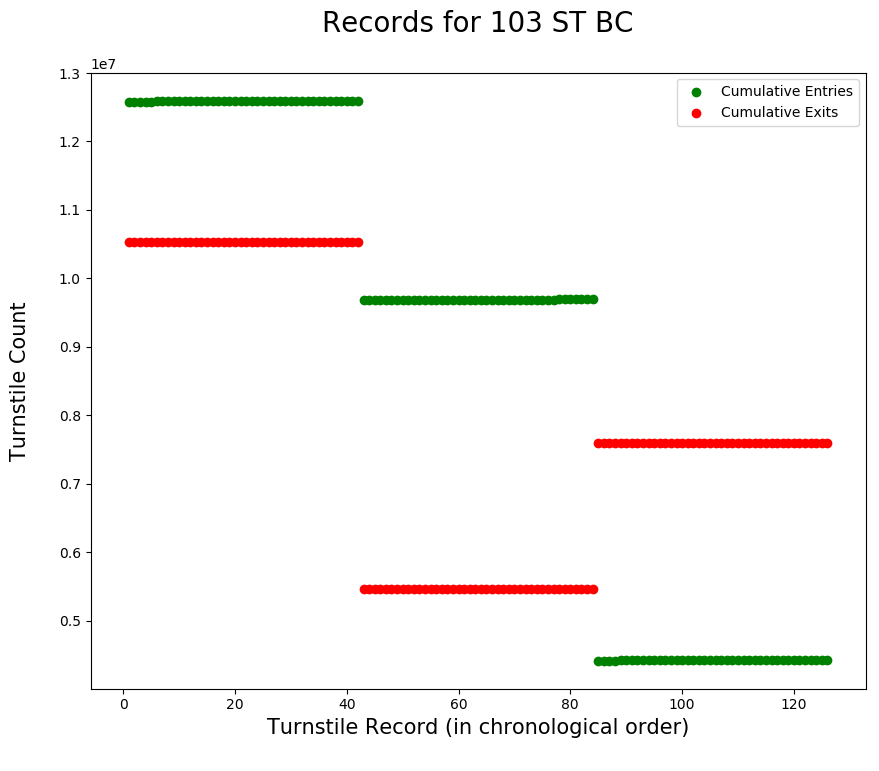

In [152]:
plt.figure(figsize = (10, 8))
#plt.style.use('presentation')
plt.scatter(x, entries, label='Cumulative Entries', color='g')
plt.scatter(x, exits, label='Cumulative Exits', color='r')
plt.xlabel('Turnstile Record (in chronological order)\n', fontsize=15)
plt.ylabel('Turnstile Count\n', fontsize=15)
plt.title('Records for 103 ST BC\n', fontsize=20)
plt.legend()
plt.savefig('Exploring Binning by SCP.png')

In [141]:
df[df['station linename'] == demo_station].groupby('scp').mean()

,cumm. entries,cumm. exits,day,entries,exits,people,timedelta,entries per hour,exits per hour,people per hour
scp,,,,,,,,,,
00-00-00,1.259e+07,1.053e+07,3.0,378.634,205.122,583.756,4.0,94.659,51.280,145.939
00-00-01,9.686e+06,5.467e+06,3.0,260.976,118.293,379.268,4.0,65.244,29.573,94.817
00-00-02,4.421e+06,7.592e+06,3.0,142.244,200.366,342.610,4.0,35.561,50.091,85.652


In [144]:
example = create_dataframe(links_dict)

In [154]:
#example.head()

In [153]:
#example[example['STATION'] == '103 ST']